# IMPROVE CUSTOMER SATISFACTION FOR EMIRATES AIRLINE 

In the service industry, keep high customer satisfaction is always among the top priority. Hence, for all airlines understanding how customers view their service through reviews are good metrics to measure the performance. Skytrax website has long been a great site for customers reviews of airlines, where it collects reviews and ratings for each airlines, lounges, seats and airports. However, there are a lot of feature ratings that an airline should consider to improve their general customer satisfaction, so it is highly important for airlines to put some priorities on which to focus and invest more effort in. 
In this project, my aim is to find the most important features that ailines should put higher weight of effort and a quantitative metrics on how to improve their ratings.

### Data
The data is scraped from airlinequality.com by quankiquanki: https://github.com/quankiquanki/skytrax-reviews-dataset. The airline dataset has a total sample of 42.396 observations with 20 columns containing information of ailines, the reviewers and their ratings for each features as well as comments on the airlines. The ratings for each feature range from 1 to 5, while overall rating is from 1 to 10. 

### Approach
* First, I build a model that can predict well the overall rating based on each feature's rating. In order to do that, I conduct OLS Linear model, Ridge linear for parameter regularization and random forest. 
* Then, I select the best model among these methods and choose the important features for airlines.
* Finally, using these features on the best models, I get the predicted rating for airlines and using this result for analyzing the possible improvement of overall rating on some feature ratings.

### Result
Random forest is the best performance on both train and test set with the lowest MSE of 1.87. The most important factors that may affect overall rating are value-money rating (46.6%), cabin staff (20.5%), seat comfort (14.5), food beverages (11%) and inflight entertainment (5.7%). Value-money rating is the most important factor, where changing from low to high rating will help overall rating increase by 2.4 point given high ratings for all other features. 

### Recommendations
* 

### Further research
* Conduct the same approach for a specific airline. 
* Do topic and sentiment analysis on the travellers' reviews for this airline to see which topics are most discussed, and alerts on negative reviews to take in-time action.


In [114]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

In [115]:
df=pd.read_csv('skytrax-reviews-dataset-master/data/airline.csv')

In [116]:
df_emi=df[df.airline_name=='emirates']
df_emi.head(2)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
14773,emirates,/airline-reviews/emirates,Emirates customer review,B Finn,Australia,2015-08-02,Overall we found the experience disappointing....,A380,FamilyLeisure,Economy,Singapore to Paris via Dubai,5.0,3.0,1.0,2.0,3.0,4.0,3.0,3.0,0
14783,emirates,/airline-reviews/emirates,Emirates customer review,Michael Leibman,South Africa,2015-07-28,Flight from Cape Town was late into Dubai due ...,Boeing 777 and A380,Couple Leisure,Business Class,Cape Town to London via Dubai,7.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,0


## Data exploration

In [117]:
df_emi.describe()

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,690.000000,691.000000,691.000000,688.000000,688.000000,61.000000,35.000000,691.000000,691.000000
mean,6.246377,3.596237,3.287988,3.453488,4.190407,3.508197,3.142857,3.609262,0.615051
std,3.088937,1.207675,1.543425,1.351322,1.075096,1.409763,1.497898,1.329978,0.486936
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN,3.000000,0.000000
50%,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,4.000000,1.000000
75%,NaN,5.000000,5.000000,NaN,NaN,NaN,NaN,5.000000,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [118]:
df_emi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 14773 to 15808
Data columns (total 20 columns):
airline_name                     691 non-null object
link                             691 non-null object
title                            691 non-null object
author                           691 non-null object
author_country                   690 non-null object
date                             691 non-null object
content                          691 non-null object
aircraft                         50 non-null object
type_traveller                   61 non-null object
cabin_flown                      691 non-null object
route                            61 non-null object
overall_rating                   690 non-null float64
seat_comfort_rating              691 non-null float64
cabin_staff_rating               691 non-null float64
food_beverages_rating            688 non-null float64
inflight_entertainment_rating    688 non-null float64
ground_service_rating            61 non

* From these descriptive tables, we see that we only have problem with missing values, but there is no outliers. Note that for some features, we see the min of rating is 0, which is invalid (from 1 to 5) so those are also missing values. 
* It is noticeable that data for overall rating, recommended and value_money rating are nearly full while rating data for ground service and wifi connectivity are mostly missing. Given this fact, it is highly likely that Emirates airlines do not offer these amenities in some routes. Hence, I think replace those missing values by 0 instead of imputed values(mean, median). 
* The data points with missing values for overall rating will be deleted as it is our main concern. 

In [119]:
df_emi.groupby('type_traveller').size()

type_traveller
Business           6
Couple Leisure    12
FamilyLeisure     22
Solo Leisure      21
dtype: int64

*With lots of missing values, when we turn traveler type into categorical variables, the sample size for these variables will be quite small.*

## Data wrangling

In the data cleaning step, I do the following:
* Only choose data since 2010
* Drop data without overall rating
* Drop information that is not needed for modelling purpose: link, title, author, author country, date, content, aircraft type, route, recommended
* Encode missing values as 0
* Get dummies for traveller type and cabin flown 

In [120]:
df_emi.date=pd.to_datetime(df_emi.date) #change date object into datetime format
df_emi=df_emi[df_emi.date>='2010-01-01'] #choose recent dates only
df_emi.shape

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(691, 20)

In [121]:
#drop data points without overall rating
df_clean=df_emi[df_emi['overall_rating'].notnull()]

In [122]:
#drop some attributes that will not be used in modelling
df_clean.drop(['airline_name','link','title','author','author_country','date','content','aircraft','route','recommended'],axis=1, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [123]:
df_clean.head()

,type_traveller,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating
14773,FamilyLeisure,Economy,5.0,3.0,1.0,2.0,3.0,4.0,3.0,3.0
14783,Couple Leisure,Business Class,7.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0
14784,Couple Leisure,Economy,9.0,5.0,4.0,4.0,5.0,4.0,NaN,5.0
14794,Couple Leisure,Business Class,10.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0
14795,FamilyLeisure,Economy,6.0,4.0,3.0,5.0,5.0,3.0,1.0,3.0


In [124]:
#deal with missing values
df_clean=df_clean.fillna({'ground_service_rating':0, 'wifi_connectivity_rating':0,'seat_comfort_rating':0,'cabin_staff_rating':0,'food_beverages_rating':0,'inflight_entertainment_rating':0, 'value_money_rating':0}, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [125]:
#change types cabin flown and traveler types into category type
df_cabin_flown= pd.get_dummies(df_clean['cabin_flown'])
df_clean=pd.concat([df_clean, df_cabin_flown], axis=1)
df_clean.drop(['cabin_flown'], axis=1, inplace=True)

df_type_traveller= pd.get_dummies(df_clean['type_traveller'])
df_clean=pd.concat([df_clean, df_type_traveller], axis=1)
df_clean.drop(['type_traveller'], axis=1, inplace=True)

In [126]:
df_clean.isnull().values.any() #check if there are any missing values in dataframe

False

In [127]:
df_clean.head()

,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,Business Class,Economy,First Class,Premium Economy,Business,Couple Leisure,FamilyLeisure,Solo Leisure
14773,5.0,3.0,1.0,2.0,3.0,4.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14783,7.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14784,9.0,5.0,4.0,4.0,5.0,4.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
14794,10.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14795,6.0,4.0,3.0,5.0,5.0,3.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [128]:
df_clean.shape

(690, 16)

## Descriptive analysis

In [129]:
df_clean.corr()

,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,Business Class,Economy,First Class,Premium Economy,Business,Couple Leisure,FamilyLeisure,Solo Leisure
overall_rating,1.000000,0.670180,0.810329,0.772947,0.568852,0.103665,0.064943,0.829394,0.074364,-0.120849,0.099232,0.046328,0.088609,0.075582,-0.057244,0.002258
seat_comfort_rating,0.670180,1.000000,0.551196,0.505741,0.459390,0.112242,0.117953,0.603930,0.106063,-0.176245,0.153644,0.044313,0.070033,0.035002,0.012336,0.002804
cabin_staff_rating,0.810329,0.551196,1.000000,0.735693,0.435756,0.105153,0.044169,0.711109,0.147460,-0.185545,0.089168,0.042244,0.093723,0.068379,-0.061072,0.004832
food_beverages_rating,0.772947,0.505741,0.735693,1.000000,0.521793,0.062415,0.069900,0.687278,0.028939,-0.090893,0.128433,0.043507,0.072633,0.054413,-0.058801,-0.020301
inflight_entertainment_rating,0.568852,0.459390,0.435756,0.521793,1.000000,0.023675,0.044062,0.543963,0.032046,-0.079792,0.100829,0.028443,0.027528,0.059177,-0.081091,-0.066321
ground_service_rating,0.103665,0.112242,0.105153,0.062415,0.023675,1.000000,0.678599,0.070685,-0.090116,0.063622,0.049846,-0.010948,0.334688,0.424046,0.482897,0.527587
wifi_connectivity_rating,0.064943,0.117953,0.044169,0.069900,0.044062,0.678599,1.000000,0.060752,-0.033380,-0.017401,0.107143,-0.007933,0.163993,0.392229,0.360858,0.348791
value_money_rating,0.829394,0.603930,0.711109,0.687278,0.543963,0.070685,0.060752,1.000000,-0.004692,-0.018545,0.047525,0.011115,0.050866,0.063894,-0.052787,-0.005559
Business Class,0.074364,0.106063,0.147460,0.028939,0.032046,-0.090116,-0.033380,-0.004692,1.000000,-0.884454,-0.144568,-0.023826,0.010869,-0.009221,-0.095148,-0.073271
Economy,-0.120849,-0.176245,-0.185545,-0.090893,-0.079792,0.063622,-0.017401,-0.018545,-0.884454,1.000000,-0.326910,-0.053877,-0.066227,-0.023518,0.093327,0.089486


*From the above table, we see that there are much correlations between cabin staff, food beverages rating and value money rating. Hence, there might be huge bias in case of OLS due to multi-colinearity*

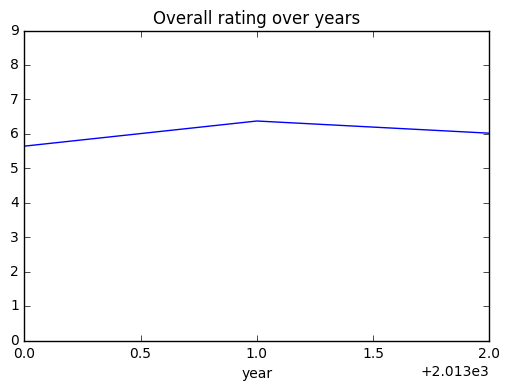

In [130]:
df_emi['year']=df_emi.date.dt.year
df_emi.groupby('year')[['overall_rating']].mean().plot()
plt.title('Overall rating over years')
plt.yticks(np.arange(0,10,1))
plt.legend().remove()
plt.show()

*The overall rating has risen slightly from around 5.7 to 6.0 point on scale of 10 in 2010-2015 period, which may suggest there has not been much improvement in rating for Emirates airlines.* 

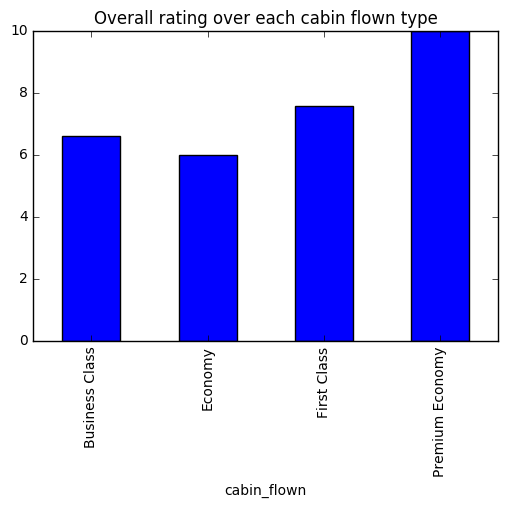

In [131]:
df_emi.groupby('cabin_flown')[['overall_rating']].mean().plot(kind='bar')
plt.title('Overall rating over each cabin flown type')
plt.legend().remove()
plt.show()

In [132]:
df_emi.groupby('cabin_flown').size()

cabin_flown
Business Class     194
Economy            461
First Class         35
Premium Economy      1
dtype: int64

*The rating is similar for economy and business class (around 6.5), while first class seems to enjoy more for Emirates service (nearly 8/10). There is only 1 data point for premium economy class, so we cannot infer much from this.*

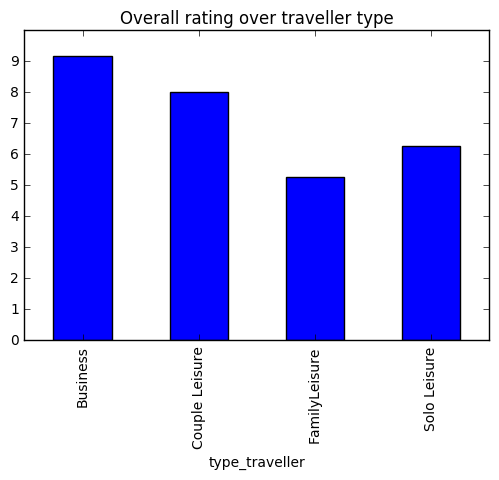

In [133]:
df_emi.groupby('type_traveller')[['overall_rating']].mean().plot(kind='bar')
plt.title('Overall rating over traveller type')
plt.yticks(np.arange(0,10,1))
plt.legend().remove()
plt.show()

*Business and couple show much more preference in Emirate services while family and solo traveller seem rather dissatisfied (less than 6 score).*

In [134]:
# Test Ho: the mean of overall rating for business/couple and family/solo traveller are equal
bi_cou=df_emi[(df_emi.type_traveller=='Business')|(df_emi.type_traveller=='Couple Leisure')].overall_rating
fa_solo=df_emi[(df_emi.type_traveller=='FamilyLeisure')|(df_emi.type_traveller=='Solo Leisure')].overall_rating
stats.ttest_ind_from_stats(bi_cou.mean(), bi_cou.std(),len(bi_cou),fa_solo.mean(), fa_solo.std(),len(fa_solo), equal_var=False)

Ttest_indResult(statistic=4.1861727820116901, pvalue=0.00010667963246993432)

*p_value< 0.01, so we can reject the null hypothesis. We may then continue to segment to see what accounts for the difference* 

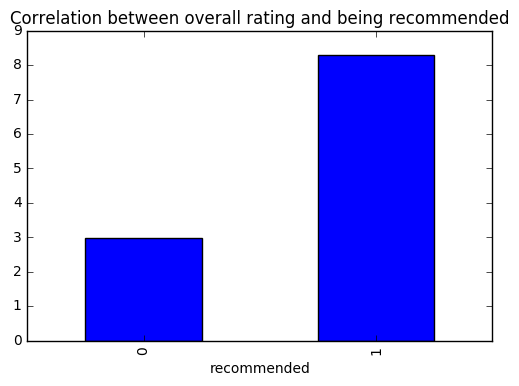

In [135]:
df_emi.groupby('recommended')[['overall_rating']].mean().plot(kind='bar')
plt.title('Correlation between overall rating and being recommended')
plt.yticks(np.arange(0,10,1))
plt.legend().remove()
plt.show()

*This shows strong positive correlation between overall rating and being recommended. Hence, we only choose one for our analysis* 

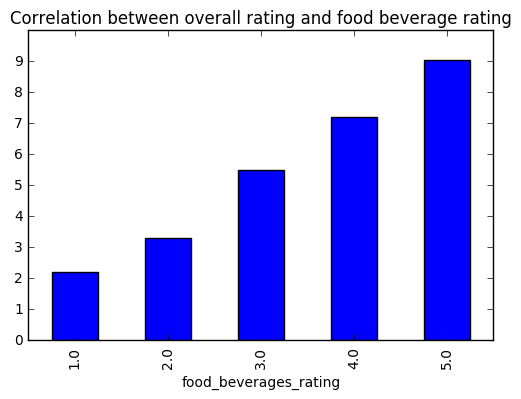

In [136]:
df_emi.groupby('food_beverages_rating')[['overall_rating']].mean().plot(kind='bar')
plt.title('Correlation between overall rating and food beverage rating')
plt.yticks(np.arange(0,10,1))
plt.legend().remove()
plt.show()

*This relationship also makes sense. The higher score for food beverages, the higher the overall score.*

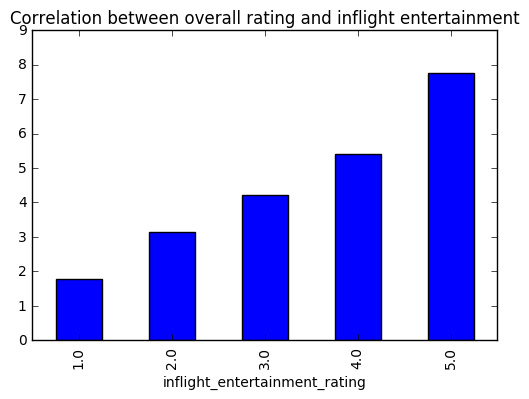

In [137]:
df_emi.groupby('inflight_entertainment_rating')[['overall_rating']].mean().plot(kind='bar')
plt.title('Correlation between overall rating and inflight entertainment')
plt.yticks(np.arange(0,10,1))
plt.legend().remove()
plt.show()

## Modelling

In order to get the most important features that may affect overall rating, the following steps are conducted:
    * Classifiers: OLS, Ridge regression,  Random forest
    * Divide dataset into train/testset (0.75/0.25), grid search and cross validation with 5 folds 
    * Metrics: mean squared error

In [138]:
y=df_clean.overall_rating
X=df_clean.drop(['overall_rating'], axis=1)

In [139]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=1)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Simple OLS

In [140]:
import statsmodels.api as sm
model=sm.OLS(ylr, Xlr)
results = model.fit()
print(results.summary())
print('mean squared error on ols:', results.mse_resid)

                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     182.3
Date:                Tue, 01 Nov 2016   Prob (F-statistic):          1.85e-186
Time:                        17:14:37   Log-Likelihood:                -850.84
No. Observations:                 517   AIC:                             1732.
Df Residuals:                     502   BIC:                             1795.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
seat_comfort_r

#### Result analysis

* Though R^2 is quite high 83%, the assumptions for OLS may not hold (multi-colinearity). Thus, the coefficients may be biased.

* Ground service, wifi connectivity and traveller type have no correlation with the overall rating as they are not statistically significant (at 5% significance level).
* MSE=1.62 (for later comparison purpose)

### Ridge regression

In [160]:
#version 1
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
from sklearn.metrics import make_scorer as scorer

ridge_model=RidgeCV(alphas=(0,0.1,0.5,0.7,1.0,5.0,7.0, 10.0,12,15,20,25), cv=5, scoring='mean_squared_error')
ridge_model.fit(Xlr,ylr)


print('alpha=', ridge_model.alpha_)
print('mean squared error on train set:', mean_squared_error(ylr,ridge_model.predict(Xlr)))
print('mean squared error on test set:', mean_squared_error(ytestlr,ridge_model.predict(Xtestlr)))


alpha= 25
mean squared error on train set: 1.5797133701
mean squared error on test set: 1.72306537139


*MSE actually keeps decreasing as regularization parameter increases. This suggests that we have underfitting problem, so in this case, I will attempt to add more polynominals in the model.

In [163]:
#version 2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
def mse(clf, X_train, y_train):
    predictions = clf.predict(X_train)
    return mean_squared_error(y_train, predictions)
alphas=[0,0.1,0.5,0.7,1,5,7, 10,12,15,20,25]
mse_min=5
best_para=[]
for i in alphas:
    score = cross_val_score(Ridge(alpha=i), Xlr, ylr, scoring=mse, cv=5)
    mse_cv=score.mean()
    if mse_cv< mse_min:
        best_para=i
        mse_min=mse_cv
print(best_para,mse_min)

25 1.65537769077


### Random forest

In [29]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
forest=RandomForestRegressor(max_features = "sqrt", random_state=1)
param_grid = { "n_estimators"      : [200, 300],
           "max_depth"         : [10, 20],
           "min_samples_split" : [2, 4]}
%timeit
grid_search = GridSearchCV(forest, param_grid, n_jobs=-1, cv=5, scoring='mean_squared_error')
grid_search.fit(Xlr, ylr)
print(grid_search.best_params_)

{'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 4}


In [30]:
best_max_depth, best_samples_splits, best_n_esti=grid_search.best_params_.values()
print('best mean squared error:',grid_search.best_score_)

best mean squared error: -1.76147231555


In [31]:
forest=RandomForestRegressor(max_features = "sqrt", random_state=1,n_estimators=best_n_esti, min_samples_split=best_samples_splits,
                             max_depth=best_max_depth).fit(Xlr,ylr)
importances = forest.feature_importances_
names=list(Xlr.columns.values)
features = []
indices = np.argsort(importances)[::-1]

for f in range(len(importances)):
    print("%d. feature %d (%f), %s" % (f + 1, indices[f], importances[indices[f]], names[indices[f]]))
    features.append(indices[f])
    # Print only first 10 most important variables
    if len(features) >= 10:
        break
featurenames = [names[feature] for feature in features]

1. feature 6 (0.402903), value_money_rating
2. feature 1 (0.259955), cabin_staff_rating
3. feature 2 (0.147647), food_beverages_rating
4. feature 0 (0.117869), seat_comfort_rating
5. feature 3 (0.028640), inflight_entertainment_rating
6. feature 8 (0.012288), Economy
7. feature 4 (0.011599), ground_service_rating
8. feature 9 (0.008017), First Class
9. feature 7 (0.005898), Business Class
10. feature 13 (0.001932), FamilyLeisure


Feature ranking:


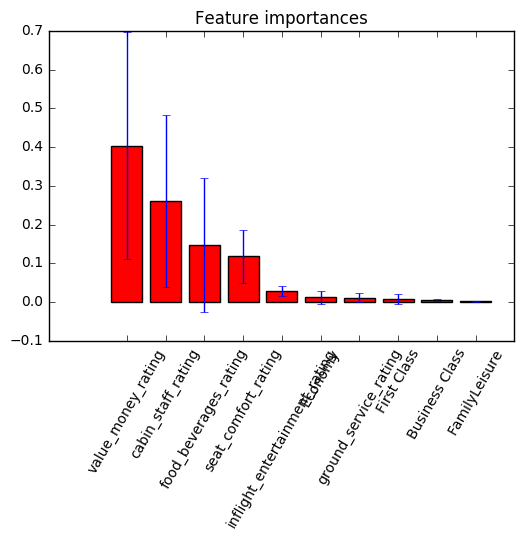

In [32]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)

# Plot the feature importances of the forest
print('Feature ranking:')
fig=plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]],
       color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(len(features)), featurenames,rotation=60)
plt.show()
fig.savefig('feature important.png')

In [33]:
print('mean squared error on train set:', mean_squared_error(ylr,forest.predict(Xlr) ))
print('mean squared error on test set:', mean_squared_error(ytestlr,forest.predict(Xtestlr)))

mean squared error on train set: 1.29789805624
mean squared error on test set: 1.67489100997


#### Result analysis

*Based on MSE, we see that Ridge regression perform the best among these 3 models for both train and test set. Hence, we will use Ridge regression for building our model.*

In the following, I group the rating for each feature where 1-3 is recorded as low, and 4-5 as high. Then, I take the median of predicted overall rating over these subsets of each feature. 

In [42]:
data_predict=Xtestlr.copy()
data_predict['value_money_low']=(data_predict.value_money_rating<=3)*1
data_predict['cabin_low']=(data_predict.cabin_staff_rating<=3)*1
data_predict['seat_comfort_low']=(data_predict.seat_comfort_rating<=3)*1
data_predict['food_beverages_low']=(data_predict.food_beverages_rating<=3)*1
data_predict['inflight_entertainment_low']=(data_predict.inflight_entertainment_rating<=3)*1
data_predict['y']=ridge_model.predict(Xtestlr)

In [39]:
pd.pivot_table(data=data_predict,columns=None, index=['value_money_low','cabin_low','seat_comfort_low','food_beverages_low','inflight_entertainment_low'],values='y', aggfunc='mean')

value_money_low  cabin_low  seat_comfort_low  food_beverages_low  inflight_entertainment_low
0                0          0                 0                   0                             9.054797
                                                                  1                             8.257525
                                              1                   0                             7.679798
                                                                  1                             7.021597
                            1                 0                   0                             7.671911
                                              1                   0                             6.787368
                 1          0                 0                   0                             6.217271
                                                                  1                             6.514782
                                              1                   0

##### The above table can be interpreted as follows:

We may go upwards or downwards in this table. If we take from bottom up, we see when everything is True, that is when every of these features have low rating, the median overall rating will be 2.538 point. Raising inflight entertainment rating from low (1-3) to high rate (4-5), the overall rating increases by nearly 1 point. And the analysis continues this way. This table can serve as a relative reference table for performance tracking purpose.  
